### Exposure to Risky Websites

1. What % of users went to a malicious website?
2. Distribution of number of malicious websites a user goes to
3. Distribution of time spent/visits by users on malicious websites

And then by age, gender, ethnicity, education

In [1]:
import pandas as pd
import numpy as np

In [2]:
yg = pd.read_csv("yg_ind_domain.csv.gz")
yg.head()

,caseid,private_domain,duration,visits
0,47541,10best.com,34,4
1,47541,1800petmeds.com,136,16
2,47541,2uf4ta.net,8,6
3,47541,3m.com,2,2
4,47541,8x8.com,404,20


In [3]:
yg['duration_min'] = yg['duration']/60

In [4]:
profile = pd.read_csv("profile.csv")
profile.head()

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region
0,200661421.0,1963.0,2,1,4,3,3,1,39,2
1,200686597.0,1992.0,2,6,5,5,8,-1,48,3
2,200953869.0,1959.0,2,1,5,2,7,2,42,1
3,201302005.0,1966.0,2,2,3,5,8,1,12,3
4,201590505.0,1977.0,1,4,5,3,3,1,6,4


In [5]:
profile['gender_lab'] = profile['gender'].replace({1: 'Male', 
                                               2: 'Female'})
profile['race_lab'] = profile['race'].replace({1: 'White', 
                                           2: 'Black', 
                                           3: 'Hispanic', 
                                           4: 'Asian', 
                                           5: 'Other', 
                                           6: 'Other',
                                           7: 'Other', 
                                           8: 'Other'})
profile['educ_lab'] = profile['educ'].replace({1: 'HS or Below',
                                           2: 'HS or Below',
                                           3: 'Some college', 
                                           4: 'Some college',
                                           5: 'College',
                                           6: 'Postgrad'})

In [6]:
vt = pd.read_csv("yg_virustotal_dat.csv")
vt.head()

,filename,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt
0,taxfoundation.org,69,0,0,18,0,financial data and services,general business,financial,NaN,NaN
1,freespincasinogo.com,65,0,0,22,0,NaN,NaN,gambling,media sharing,NaN
2,nascar.com,68,0,0,19,0,sports,sports,sports,unknown,"Hobbies/Recreation, Sports"
3,hugregregy.pro,65,1,0,21,0,NaN,NaN,NaN,media sharing,NaN
4,inxxx.com,67,0,0,20,0,sex,NaN,porn,media sharing,NaN


In [7]:
# Let's assume that virustotal data is missing at random so only get domains for which we have virustotal data
yg_vt = pd.merge(yg, vt, left_on='private_domain', right_on = 'filename', how = 'inner')
yg_vt.head()

,caseid,private_domain,duration,visits,duration_min,filename,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt
0,47541,2uf4ta.net,8,6,0.133333,2uf4ta.net,65,0,0,22,0,NaN,NaN,NaN,media sharing,NaN
1,47541,3m.com,2,2,0.033333,3m.com,70,0,0,17,0,business and economy,general business,business,NaN,Business/Economy
2,1585201,3m.com,28,3,0.466667,3m.com,70,0,0,17,0,business and economy,general business,business,NaN,Business/Economy
3,273543945,3m.com,262,15,4.366667,3m.com,70,0,0,17,0,business and economy,general business,business,NaN,Business/Economy
4,47541,8x8.com,404,20,6.733333,8x8.com,70,0,0,17,0,information technology,information technology,im,NaN,Information Technology


In [8]:
yg_vt['private_domain'].nunique()

27660

In [9]:
yg_vt['malicious_bool'] = yg_vt['malicious'].astype('bool')
yg_vt['malicious_visits'] = yg_vt['malicious'] * yg_vt['visits']
yg_vt['malicious_time'] = yg_vt['malicious'] * yg_vt['duration_min']

In [10]:
yg_vt_resp = yg_vt[['caseid', 'malicious_bool', 'malicious_visits', 'malicious_time']].groupby('caseid').sum().astype(int).reset_index()
yg_vt_resp.head()

,caseid,malicious_bool,malicious_visits,malicious_time
0,47541,9,728,97
1,56565,7,301,46
2,203271,7,103,14
3,216457,1,2,0
4,257495,13,249,37


In [11]:
# Join to profile
fin_dat = profile.merge(yg_vt_resp, on = "caseid", how = "left")
fin_dat.head()

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,malicious_bool,malicious_visits,malicious_time
0,200661421.0,1963.0,2,1,4,3,3,1,39,2,Female,White,Some college,2.0,10.0,4.0
1,200686597.0,1992.0,2,6,5,5,8,-1,48,3,Female,Other,College,6.0,15.0,3.0
2,200953869.0,1959.0,2,1,5,2,7,2,42,1,Female,White,College,0.0,0.0,0.0
3,201302005.0,1966.0,2,2,3,5,8,1,12,3,Female,Black,Some college,3.0,10.0,0.0
4,201590505.0,1977.0,1,4,5,3,3,1,6,4,Male,Asian,College,1.0,4.0,2.0


In [12]:
fin_dat[['malicious_bool', 'malicious_bool', 'malicious_visits', 'malicious_time']].describe().astype(int)

,malicious_bool,malicious_bool,malicious_visits,malicious_time
count,1132,1132,1132,1132
mean,4,4,133,137
std,7,7,517,1839
min,0,0,0,0
25%,0,0,0,0
50%,2,2,10,3
75%,5,5,61,22
max,126,126,10217,51376


In [13]:
percentiles = [25, 50, 75]
gen_order = columns=['gender_lab', 'count', 'mean', 'std', 'min', 25, 50, 75, 'max']

gender_summary = fin_dat.groupby('gender_lab')['malicious_bool'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
percentile_values = fin_dat.groupby('gender_lab')['malicious_bool'].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().reset_index()
gender_summary = pd.merge(gender_summary, percentile_values).round(1)
print(gender_summary.reindex(columns=[col for col in gen_order if col in gender_summary.columns]))

  gender_lab  count  mean  std  min   25   50   75    max
0     Female    595   3.6  6.1  0.0  0.0  2.0  4.0   66.0
1       Male    537   4.4  8.0  0.0  0.0  2.0  6.0  126.0


In [15]:
gender_summary = fin_dat.groupby('gender_lab')['malicious_time'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
percentile_values = fin_dat.groupby('gender_lab')['malicious_time'].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().reset_index()
gender_summary = pd.merge(gender_summary, percentile_values).round(1)
print(gender_summary.reindex(columns=[col for col in gen_order if col in gender_summary.columns]))

  gender_lab  count   mean     std  min   25   50    75      max
0     Female    595   69.2   491.2  0.0  0.0  2.0  17.5   9422.0
1       Male    537  212.2  2619.0  0.0  0.0  4.0  25.0  51376.0


In [16]:
race_order = columns=['race_lab', 'count', 'mean', 'std', 'min', 25, 50, 75, 'max']

race_summary = fin_dat.groupby('race_lab')['malicious_bool'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
percentile_values = fin_dat.groupby('race_lab')['malicious_bool'].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().reset_index()
race_summary = pd.merge(race_summary, percentile_values).round(1)
print(race_summary.iloc[[4, 1, 2, 0, 3]].reindex(columns=[col for col in race_order if col in race_summary.columns]))

   race_lab  count  mean   std  min   25   50   75    max
4     White    719   3.9   5.9  0.0  0.0  2.0  5.0   63.0
1     Black    144   5.5  13.2  0.0  0.0  2.0  5.0  126.0
2  Hispanic    167   3.4   4.7  0.0  0.0  2.0  4.0   25.0
0     Asian     46   3.7   5.5  0.0  1.0  1.5  4.0   22.0
3     Other     56   3.5   4.6  0.0  1.0  2.0  4.0   19.0


In [17]:
race_summary = fin_dat.groupby('race_lab')['malicious_time'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
percentile_values = fin_dat.groupby('race_lab')['malicious_time'].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().reset_index()
race_summary = pd.merge(race_summary, percentile_values).round(1)
print(race_summary.iloc[[4, 1, 2, 0, 3]].reindex(columns=[col for col in race_order if col in race_summary.columns]))

   race_lab  count   mean     std  min   25   50    75      max
4     White    719   57.7   438.1  0.0  0.0  3.0  22.0   9422.0
1     Black    144  665.5  5019.7  0.0  0.0  3.0  37.8  51376.0
2  Hispanic    167   63.7   427.2  0.0  0.0  2.0  14.0   5388.0
0     Asian     46   72.2   285.3  0.0  0.0  3.5  18.0   1871.0
3     Other     56   68.8   280.8  0.0  0.0  3.0  24.0   1931.0


In [18]:
educ_order = columns=['educ_lab', 'count', 'mean', 'std', 'min', 25, 50, 75, 'max']

educ_summary = fin_dat.groupby('educ_lab')['malicious_bool'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
percentile_values = fin_dat.groupby('educ_lab')['malicious_bool'].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().reset_index()
educ_summary = pd.merge(educ_summary, percentile_values).round(1)
print(educ_summary.iloc[[1, 3, 0, 2]].reindex(columns=[col for col in educ_order if col in educ_summary.columns]))

       educ_lab  count  mean  std  min   25   50   75    max
1   HS or Below    410   4.2  7.0  0.0  1.0  2.0  5.0   66.0
3  Some college    326   4.2  8.9  0.0  0.0  2.0  4.8  126.0
0       College    254   3.9  5.5  0.0  0.0  2.0  6.0   42.0
2      Postgrad    142   3.3  5.0  0.0  0.0  1.0  4.0   35.0


In [19]:
educ_summary = fin_dat.groupby('educ_lab')['malicious_time'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
percentile_values = fin_dat.groupby('educ_lab')['malicious_time'].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().reset_index()
educ_summary = pd.merge(educ_summary, percentile_values).round(1)
print(educ_summary.iloc[[1, 3, 0, 2]].reindex(columns=[col for col in educ_order if col in educ_summary.columns]))

       educ_lab  count   mean     std  min   25   50    75      max
1   HS or Below    410   77.8   556.6  0.0  0.0  3.0  23.0   9422.0
3  Some college    326  212.2  2849.3  0.0  0.0  3.0  19.8  51376.0
0       College    254  191.9  2038.7  0.0  0.0  3.0  25.8  31874.0
2      Postgrad    142   37.3   150.8  0.0  0.0  2.0  12.0   1482.0


<Figure size 800x600 with 0 Axes>

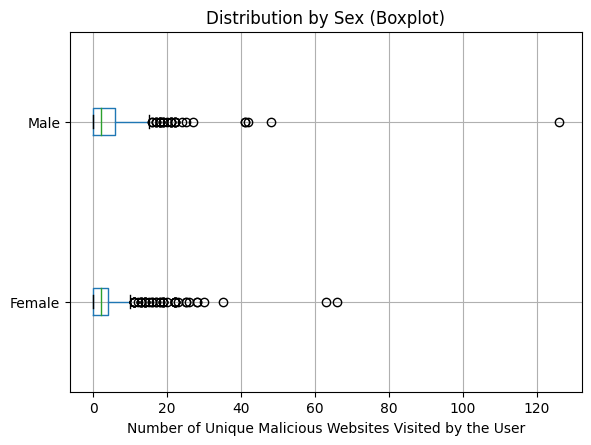

In [22]:
# Plot the distribution
import matplotlib.pyplot as plt

# Create a box plot by group
plt.figure(figsize=(8, 6))
fin_dat['gender_lab_enc'] = pd.factorize(fin_dat['gender_lab'])[0] + 1

label_mapping = dict(zip(fin_dat['gender_lab_enc'], fin_dat['gender_lab']))

ax = fin_dat.boxplot(column='malicious_bool', by='gender_lab_enc', vert=False)


# Set x-axis ticks and labels
ticks = list(label_mapping.keys())
labels = list(label_mapping.values())
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

plt.xlabel('Number of Unique Malicious Websites Visited by the User')
plt.ylabel('')
plt.title('Distribution by Sex (Boxplot)')
plt.suptitle('')
plt.show()